In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('..')
import rwpropa as rw

## Simulation setup

We use the same simulation from Tutorial 1 with a different propagation module.

In [2]:
sim = rw.Simulation()

start simulation


### Source 

First, we have to define a source of particles that we want to propagate. The simples source type is the point source that emmits particles isotropically. The only user-specifyed parameters are:

- **energy**: Energy of the particles in eV.
- **source posistion**: The position of the point source.
- **number of particles**: Number of particles that should be emitted from this source.

The source can be easily added to the simulation. Afterwards, calling the description on the source of the simulation prints all relevant information and the values of the source parameters.

In [3]:
nr_particles = 10**3
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
energy = 3*10**15 # eV
phi = 0.0
pitch_angle = 2*np.pi * 54.74/360 # pitch angle for equal components in all directions

source = rw.PointSourceIsotropicPhi(energy, source_pos, nr_particles)
sim.add_source(source)
sim.source.get_description()

Description Source:
                The source defines the start conditions of the particles 
                and covers the position, direction, energy, etc

position:  [0. 0. 0.]
number particles:  1000
energy:  3000000000000000  eV
source tpye: PointSourceIsotropic


### Propagator

Propagates particles via a correlated rrandom walk. The overall behaviour is governed by a generalized telegraph equation: $\frac{\partial f}{\partial t} = \sum_i \tau_i \frac{\partial^2 f}{\partial t^2} = \sum_i \kappa_i \frac{\partial^2 f}{\partial x_i^2}$.

Here, we use isotropic diffusion for simplicity that propagates particles using a correlated random walk in Cartesian coordinates. Isotropic diffusion is given when the turbulence is isotropic and there is no background field. In the following tutorials also the anisotropic diffusion is used. The only user-specifyed parameters for the simple case of isotropic diffusion are:

- **mean-free paths**: The mean-free paths $\lambda_i$ can be derived from the diffusion coefficients $\kappa_i$ via $\lambda_i = 3 \kappa_i/c$. Therfore, the diagonal elements of the diagonalized diffusion tensor are needed to determine the characteristics of the transport. For isotropic diffusion all diffusion coefficients are equal $\kappa = [\kappa_{xx}, \kappa_{yy}, \kappa_{zz}]$ with $\kappa_{xx}=\kappa_{yy}=\kappa_{zz}$. Typical free-mean paths of charged particles in plasmoids in AGN jets are $10^{12}$m (see Reichherzer et al. (2021)).
- **number of steps**: The number of simulation steps for each individual particle.
- **step size**: Size of an individual step. Together with the parameter number of steps, the step size determines the trajectory length of the particles. 

The propagator can be easily added to the simulation. Afterwards, calling the description on the propagator of the simulation prints all relevant information and the values of the propagation parameters.

In [4]:
nr_steps = 10**4
step_size = 0.5*10**10 # [m]
diffusion_coefficient = 5*10**18 # [m^2/s]
speed_of_light = 3*10**8 # [m/s]
mfp_iso = 3*diffusion_coefficient/speed_of_light
mfp = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12], dtype=np.float32)  # [m]
rms = 1 # Gaus
magnetic_field = rw.OrderedBackgroundField(rms, [0,0,1]).magnetic_field

propagator = rw.AnisotropicPropagator(magnetic_field, mfp, nr_steps, step_size)
sim.add_propagator(propagator)
sim.propagator.get_description()

Propagator initialized
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

propagation tpye: AnisotropicPropagator
Description Propagator:
                The propagator is responsible for the movement of the particles. 
                It performs the change of direction and the movement in the respective direction.
                There are two phases:
                 - change direction with probability (see below)
                 - move in all directions
                The movement takes place according to the random walk (RW).

coordinates: Cylindrical coordinates
dimensions:  3
pitch angle: constant
particle sp

### Observer

The Observer determines during the simulation when and what data to write out (observe).

In each simulation step, the current particle state is evaluated by the Observer to check
if one of the observing contions is satisfyed. The conditions to observe can be based 
on the time (-> step) or the coordinates of the particle.

The conditions to observe can be based on the time (or step) or the coordinates of 
    the particle.
    
- step number [unique_steps] -> time (TimeEvolutionObservers)
- radius of observer sphere [shperes] -> sphere around source (SphericalObservers)
- cartesian coordinates [box_dimensions] -> box around source (BoxObserver) (not yet implemented)
   
All special observer will create an Observer object and specify the relevant parameters
for the observation conditions (unique_steps, shperes, box_dimensions)

In [5]:
substeps = [False, False, True] # observe only steps (no substeps)
min_step = 1
max_step = nr_steps
nr_obs_steps = 200

observer = rw.TimeEvolutionObserverLog(min_step, max_step, nr_obs_steps, substeps)

sim.add_observer(observer)
sim.observer.get_description()

Observer initialized
Description Observer:
                The observer defines the conditions for when to write data to the output.

observer tpye: TimeEvolutionObserverLog
spheres:  [-1.]
steps [0:10]:  [ 1  2  3  4  5  6  7  8  9 10]
steps [-11:-1]:  [6294 6593 6905 7232 7575 7934 8309 8703 9115 9547]
nr steps:  154
substeps:  [False False  True]
all_steps:  False


In [6]:
%time sim.run_simulation()
sim.save_data('data/data_tut_2')

CPU times: user 33 s, sys: 36.4 ms, total: 33 s
Wall time: 33 s


## Analyze statistics

#### Diffusion coefficients

As the particles propagate via a random walk, statistical properties 
of many particles are interesting, such as the diffusion coefficients and
particle distributions. These quantities can be compared to analytical 
predictions.

Running diffusion coefficients are computed with the mean-squared displacement method:

$\kappa_{ii}(t) = \frac{<\Delta x_i^2>}{2t}$.

init statistics plotting class


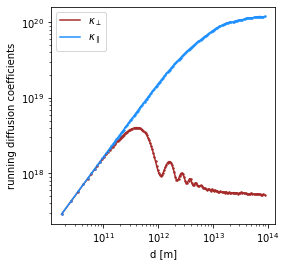

input kappa: 5e+18 m²/s
kappa_{xx}: 5.34e+17 m²/s +- 1.27e+16 m²/s
kappa_{yy}: 5.18e+17 m²/s +- 8.9e+15 m²/s
kappa_{zz}: 1.19e+20 m²/s +- 1e+18 m²/s


In [7]:
df = pd.read_pickle("data/data_tut_2.pkl")
df_time_evolution_observer = df.loc[df['radius'] == -1.0]

sta = rw.Statistics(df_time_evolution_observer)
isotropic = False # diffusion is anisotropic
errors = False # don't show error bars
df_kappas = sta.plot_diffusion_coefficients(isotropic, errors)
print('input kappa:', f"{float(diffusion_coefficient):.3}", 'm²/s')
n = 10
print('kappa_{xx}:', f"{np.mean(df_kappas['kappa_xx'][-n:]):.3}", 'm²/s', '+-', f"{np.std(df_kappas['kappa_xx'][-n:]):.3}", 'm²/s')
print('kappa_{yy}:', f"{np.mean(df_kappas['kappa_yy'][-n:]):.3}", 'm²/s', '+-', f"{np.std(df_kappas['kappa_yy'][-n:]):.3}", 'm²/s')
print('kappa_{zz}:', f"{np.mean(df_kappas['kappa_zz'][-n:]):.3}", 'm²/s', '+-', f"{np.std(df_kappas['kappa_zz'][-n:]):.3}", 'm²/s')

In [11]:
df

,id,i,d,x,y,z,phi,pitch_angle,radius,sub_step
0,0.0,1.0,1.637957e+10,8.874545e+08,-9.693628e+09,-2.805313e+09,4.062341,1.855144,-1.0,2.0
1,0.0,2.0,2.456935e+10,1.756325e+09,-1.448466e+10,-4.207969e+09,4.121080,1.855144,-1.0,2.0
2,0.0,3.0,3.275914e+10,2.904963e+09,-1.921642e+10,-5.610626e+09,4.179820,1.855144,-1.0,2.0
3,0.0,4.0,4.094892e+10,4.329398e+09,-2.387258e+10,-7.013282e+09,4.238560,1.855144,-1.0,2.0
4,0.0,5.0,4.913871e+10,6.024724e+09,-2.843709e+10,-8.415938e+09,4.297299,1.855144,-1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
153995,999.0,8309.0,6.330190e+13,-3.217816e+11,5.960814e+11,-6.982097e+12,44.823349,0.459507,-1.0,2.0
153996,999.0,8703.0,6.630294e+13,-2.515879e+11,5.250181e+11,-8.747853e+12,42.869431,0.459507,-1.0,2.0
153997,999.0,9115.0,6.944109e+13,-3.776943e+11,7.811492e+11,-1.059428e+13,33.805420,0.459507,-1.0,2.0
153998,999.0,9547.0,7.273157e+13,-3.162507e+11,9.442454e+11,-8.694074e+12,27.075256,0.459507,-1.0,2.0
